# Dados da Comex e estatísitca para complexidade econômica

Os dados da comex para as exportações dos estados brasileiros em frequência anual foram importados e uma estatística como proxy para complexidade econômica ([Mealy et al. 2018](https://oms-inet.files.svdcdn.com/staging/files/main_feb4.pdf)) e variedade da economia de cada estado foi proposta e calculada. A estatística é uma mistura da entropia de Shannon com a ideia da transformação *tf-idf* feita em trabalhos de processamento de linguagem natural ([Blei, 2003](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)). A fórmula é a seguinte: 

$$I(j,t) = -\sum^{n}_{i=1}p(i,j,t)(ln(p(i,j,t)) + ln(f(i,t)))$$

Onde $i$ é o produto classificado pelo NCM, $j$ é o estado e $t$ é o período. $p(i,j,t)$ é então a frequência do produto $i$ na pauta de exportações do estado $j$ no ano $t$. Similarmente, $f$ é a frequência que o produto é exportado por qualquer estado. $ln(x)$ é o logaritmo natural. A ideia é de que quanto mais um produto é frequentemente exportado por um estado  (medido por $p$) menos diversificada é sua pauta de exportações. Como $p<1$, temos que $ln(p) < 0$. Considerando o sinal à esquerda do somatório, temos que $-ln(p) = ln\left(\frac{1}{p}\right)$. Dessa forma, $-ln(p)$ é uma função decrescente em $p$ e, portanto, quanto menos frequente for o produto, maior é o valor de $-ln(p)$. Simlarmente, $f$ entra no cálculo do índice por ser uma proxy de quão raro o produto é entre os estados. Assim, se o estado estiver exportando produtos que são pouco exportados pelos outros estados, isso serve de proxy para indicar que ele possui uma sofisticação produtiva e é capaz de produzir itens mais raros. O índice é então utilizado para estimar uma regressão de dados em painel com efeitos fixos e efeitos de tempo com a renda per capita servindo de variável endógena. O coeficiente estimado para o índice é positivo e extremamente significativo, apesar de o $R^2$ ser bem baixo.

##### Sobre os dados: 

Os dados da COMEX geram um arquivo csv de 1,81gb. Portanto, não podem ser colocados no github. 

##### Fontes dos dados: 

[COMEX](https://comexstat.mdic.gov.br/pt/geral)

[ipeadata](http://www.ipeadata.gov.br/Default.aspx)

# Importando os pacotes necessários

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

C:\Users\joaop\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Importando os dados

In [2]:
# importando os dados e separando os quatro primeiros dígitos do ncm 

df = pd.read_csv("EXP_COMPLETA.csv", sep = ';')

df['codigos'] = df['CO_NCM'].astype(str).str[:-4]

df

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,codigos
0,1997,11,20079990,10,158,RJ,4,717700,0,200,540,2007
1,1997,11,48064000,10,63,SP,7,1010900,0,58792,90186,4806
2,1997,11,2071300,10,351,SC,1,925100,0,57165,20767,207
3,1997,11,19021100,10,586,MS,9,910600,0,12,9,1902
4,1997,11,90319090,10,40,ND,4,717700,0,6,250,9031
...,...,...,...,...,...,...,...,...,...,...,...,...
29172726,2025,1,84834090,11,776,SP,4,817600,1,0,25,8483
29172727,2025,1,19059090,10,158,SP,7,1017500,245,245,1152,1905
29172728,2025,1,21039021,10,628,PA,1,217800,2,2,3,2103
29172729,2025,1,2071412,10,154,DF,1,927700,7500,7500,7633,207


In [3]:
# ajeitando as variáveis classificatórias

df['CO_NCM'] = df['CO_NCM'].astype(str).str.zfill(8)

df['codigos'] = df['codigos'].astype(str).str.zfill(4)

df['CO_PAIS'] = df['CO_PAIS'].astype(str).str.zfill(3)

df.dtypes

CO_ANO         int64
CO_MES         int64
CO_NCM        object
CO_UNID        int64
CO_PAIS       object
SG_UF_NCM     object
CO_VIA         int64
CO_URF         int64
QT_ESTAT       int64
KG_LIQUIDO     int64
VL_FOB         int64
codigos       object
dtype: object

# Calculando $p(i,j,t)$

In [4]:
# Definindo a função para calcular a entropia de Shannon

def entrop(produtos): 
    
    index = -np.sum(produtos.value_counts(normalize = True)*np.log(produtos.value_counts(normalize = True)))
    
    return index

In [5]:
# Aplicando a função e criando o nome de uma nova coluna

A = df[['CO_ANO','CO_NCM','SG_UF_NCM']].groupby(['SG_UF_NCM','CO_ANO'], as_index = False).apply(entrop)
A = A.rename(columns = {None:'entrop'})

C:\Users\joaop\AppData\Local\Temp\ipykernel_30180\3402638171.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  A = df[['CO_ANO','CO_NCM','SG_UF_NCM']].groupby(['SG_UF_NCM','CO_ANO'], as_index = False).apply(entrop)


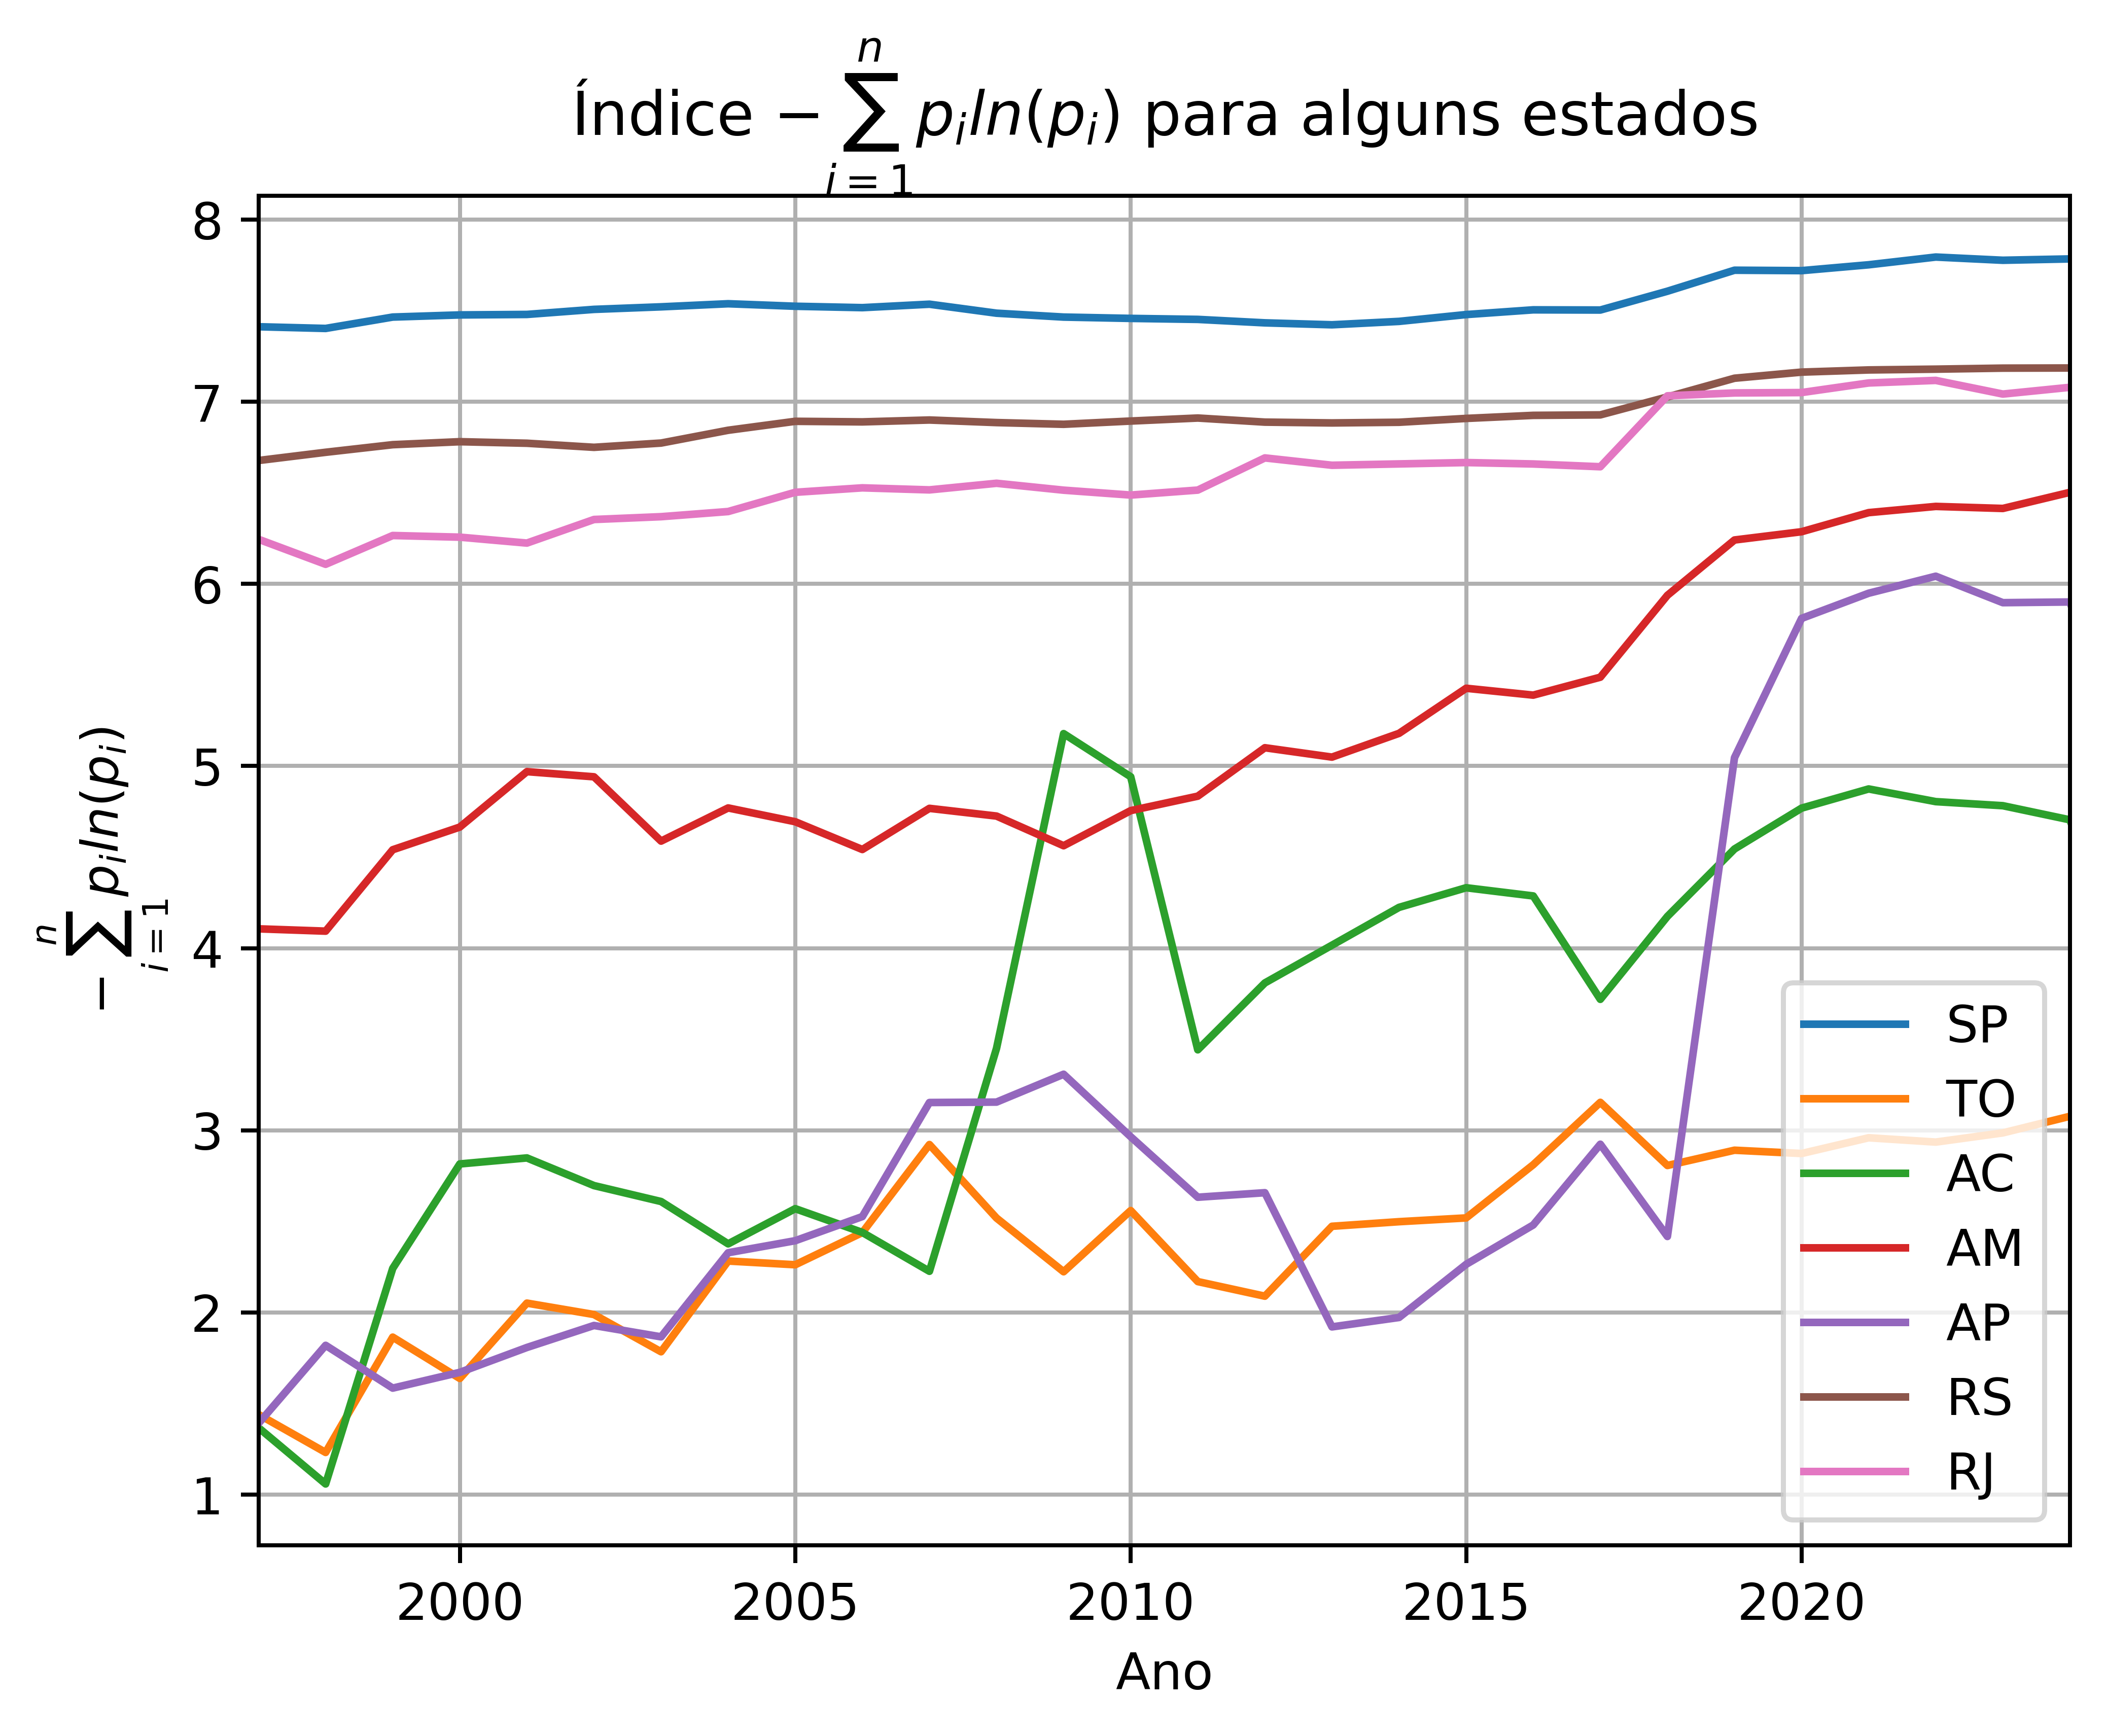

In [6]:
# Plotando os valores em um gráfico 

estados = ['SP','TO','AC','AM','AP','RS','RJ']

fig, ax = plt.subplots(dpi = 720)

for estado in estados: 
    
    ax.plot(A['CO_ANO'].unique(), A.loc[A['SG_UF_NCM'] == estado, 'entrop'], label = estado)
    
ax.grid()

ax.set_xlim(1997,2024)

ax.set(xlabel = 'Ano',
       ylabel = r'$-\sum^{n}_{i = 1}p_i ln(p_i)$',
       title = r'Índice $-\sum^{n}_{i = 1}p_i ln(p_i)$ para alguns estados')
    
ax.legend()

# Calculando f

In [7]:
# log do inverso das proporções

B = df[['CO_ANO','CO_NCM']].groupby('CO_ANO', as_index = False).apply(lambda x: -np.log(x.value_counts(normalize = True)))

B = pd.DataFrame(B).reset_index().rename(columns = {'proportion':'log-exportação'})

B

C:\Users\joaop\AppData\Local\Temp\ipykernel_30180\3611501326.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  B = df[['CO_ANO','CO_NCM']].groupby('CO_ANO', as_index = False).apply(lambda x: -np.log(x.value_counts(normalize = True)))


,level_0,CO_ANO,CO_NCM,log-exportação
0,0,1997,87089900,4.829853
1,0,1997,40169300,4.985778
2,0,1997,99997103,5.094181
3,0,1997,73181500,5.107504
4,0,1997,39269090,5.318556
...,...,...,...,...
211517,28,2025,60012200,11.748653
211518,28,2025,60012100,11.748653
211519,28,2025,60011090,11.748653
211520,28,2025,59050000,11.748653


In [8]:
# proporção dos produtos nas pautas de cada estado

C = df[['CO_ANO','SG_UF_NCM','CO_NCM']].groupby(['CO_ANO','SG_UF_NCM'], as_index = False).apply(lambda x: x.value_counts(normalize = True))

C = pd.DataFrame(C).reset_index().rename(columns = {'proportion':'share-exp-estado'})

C

C:\Users\joaop\AppData\Local\Temp\ipykernel_30180\4056757258.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  C = df[['CO_ANO','SG_UF_NCM','CO_NCM']].groupby(['CO_ANO','SG_UF_NCM'], as_index = False).apply(lambda x: x.value_counts(normalize = True))


,level_0,CO_ANO,SG_UF_NCM,CO_NCM,share-exp-estado
0,0,1997,AC,99980102,0.454545
1,0,1997,AC,44079990,0.272727
2,0,1997,AC,08012100,0.090909
3,0,1997,AC,44072910,0.090909
4,0,1997,AC,44092000,0.090909
...,...,...,...,...,...
1015822,872,2025,TO,26020090,0.006536
1015823,872,2025,TO,05100090,0.006536
1015824,872,2025,TO,46021900,0.006536
1015825,872,2025,TO,05069000,0.006536


In [9]:
# juntando as duas bases

D = pd.merge(B,C,on = ['CO_ANO','CO_NCM'], how = 'right')

D

,level_0_x,CO_ANO,CO_NCM,log-exportação,level_0_y,SG_UF_NCM,share-exp-estado
0,0,1997,99980102,7.211576,0,AC,0.454545
1,0,1997,44079990,6.171778,0,AC,0.272727
2,0,1997,08012100,8.823574,0,AC,0.090909
3,0,1997,44072910,7.473173,0,AC,0.090909
4,0,1997,44092000,6.983839,0,AC,0.090909
...,...,...,...,...,...,...,...
1015822,28,2025,26020090,9.802743,872,TO,0.006536
1015823,28,2025,05100090,8.613159,872,TO,0.006536
1015824,28,2025,46021900,9.669212,872,TO,0.006536
1015825,28,2025,05069000,8.858282,872,TO,0.006536


In [10]:
# juntando e somando

D['entropia'] = D['log-exportação']*D['share-exp-estado']

D = D[['CO_ANO','SG_UF_NCM','entropia']].groupby(['CO_ANO','SG_UF_NCM'], as_index = False).sum()

# Juntando $p$ e $f$ na estatística final para $I(j,t)$

In [11]:
# Juntando a base de dados final

df_final = pd.merge(A,D, on = ['SG_UF_NCM','CO_ANO'])

df_final['entropia final'] = df_final['entrop'] + df_final['entropia']

df_final

,SG_UF_NCM,CO_ANO,entrop,entropia,entropia final
0,AC,1997,1.366711,7.077618,8.444329
1,AC,1998,1.057905,7.752297,8.810202
2,AC,1999,2.241563,7.250720,9.492283
3,AC,2000,2.815157,6.956234,9.771391
4,AC,2001,2.848207,6.633558,9.481765
...,...,...,...,...,...
868,ZN,2011,7.178754,7.563929,14.742683
869,ZN,2012,7.143110,7.560951,14.704062
870,ZN,2013,7.103645,7.529665,14.633310
871,ZN,2014,7.086971,7.504867,14.591838


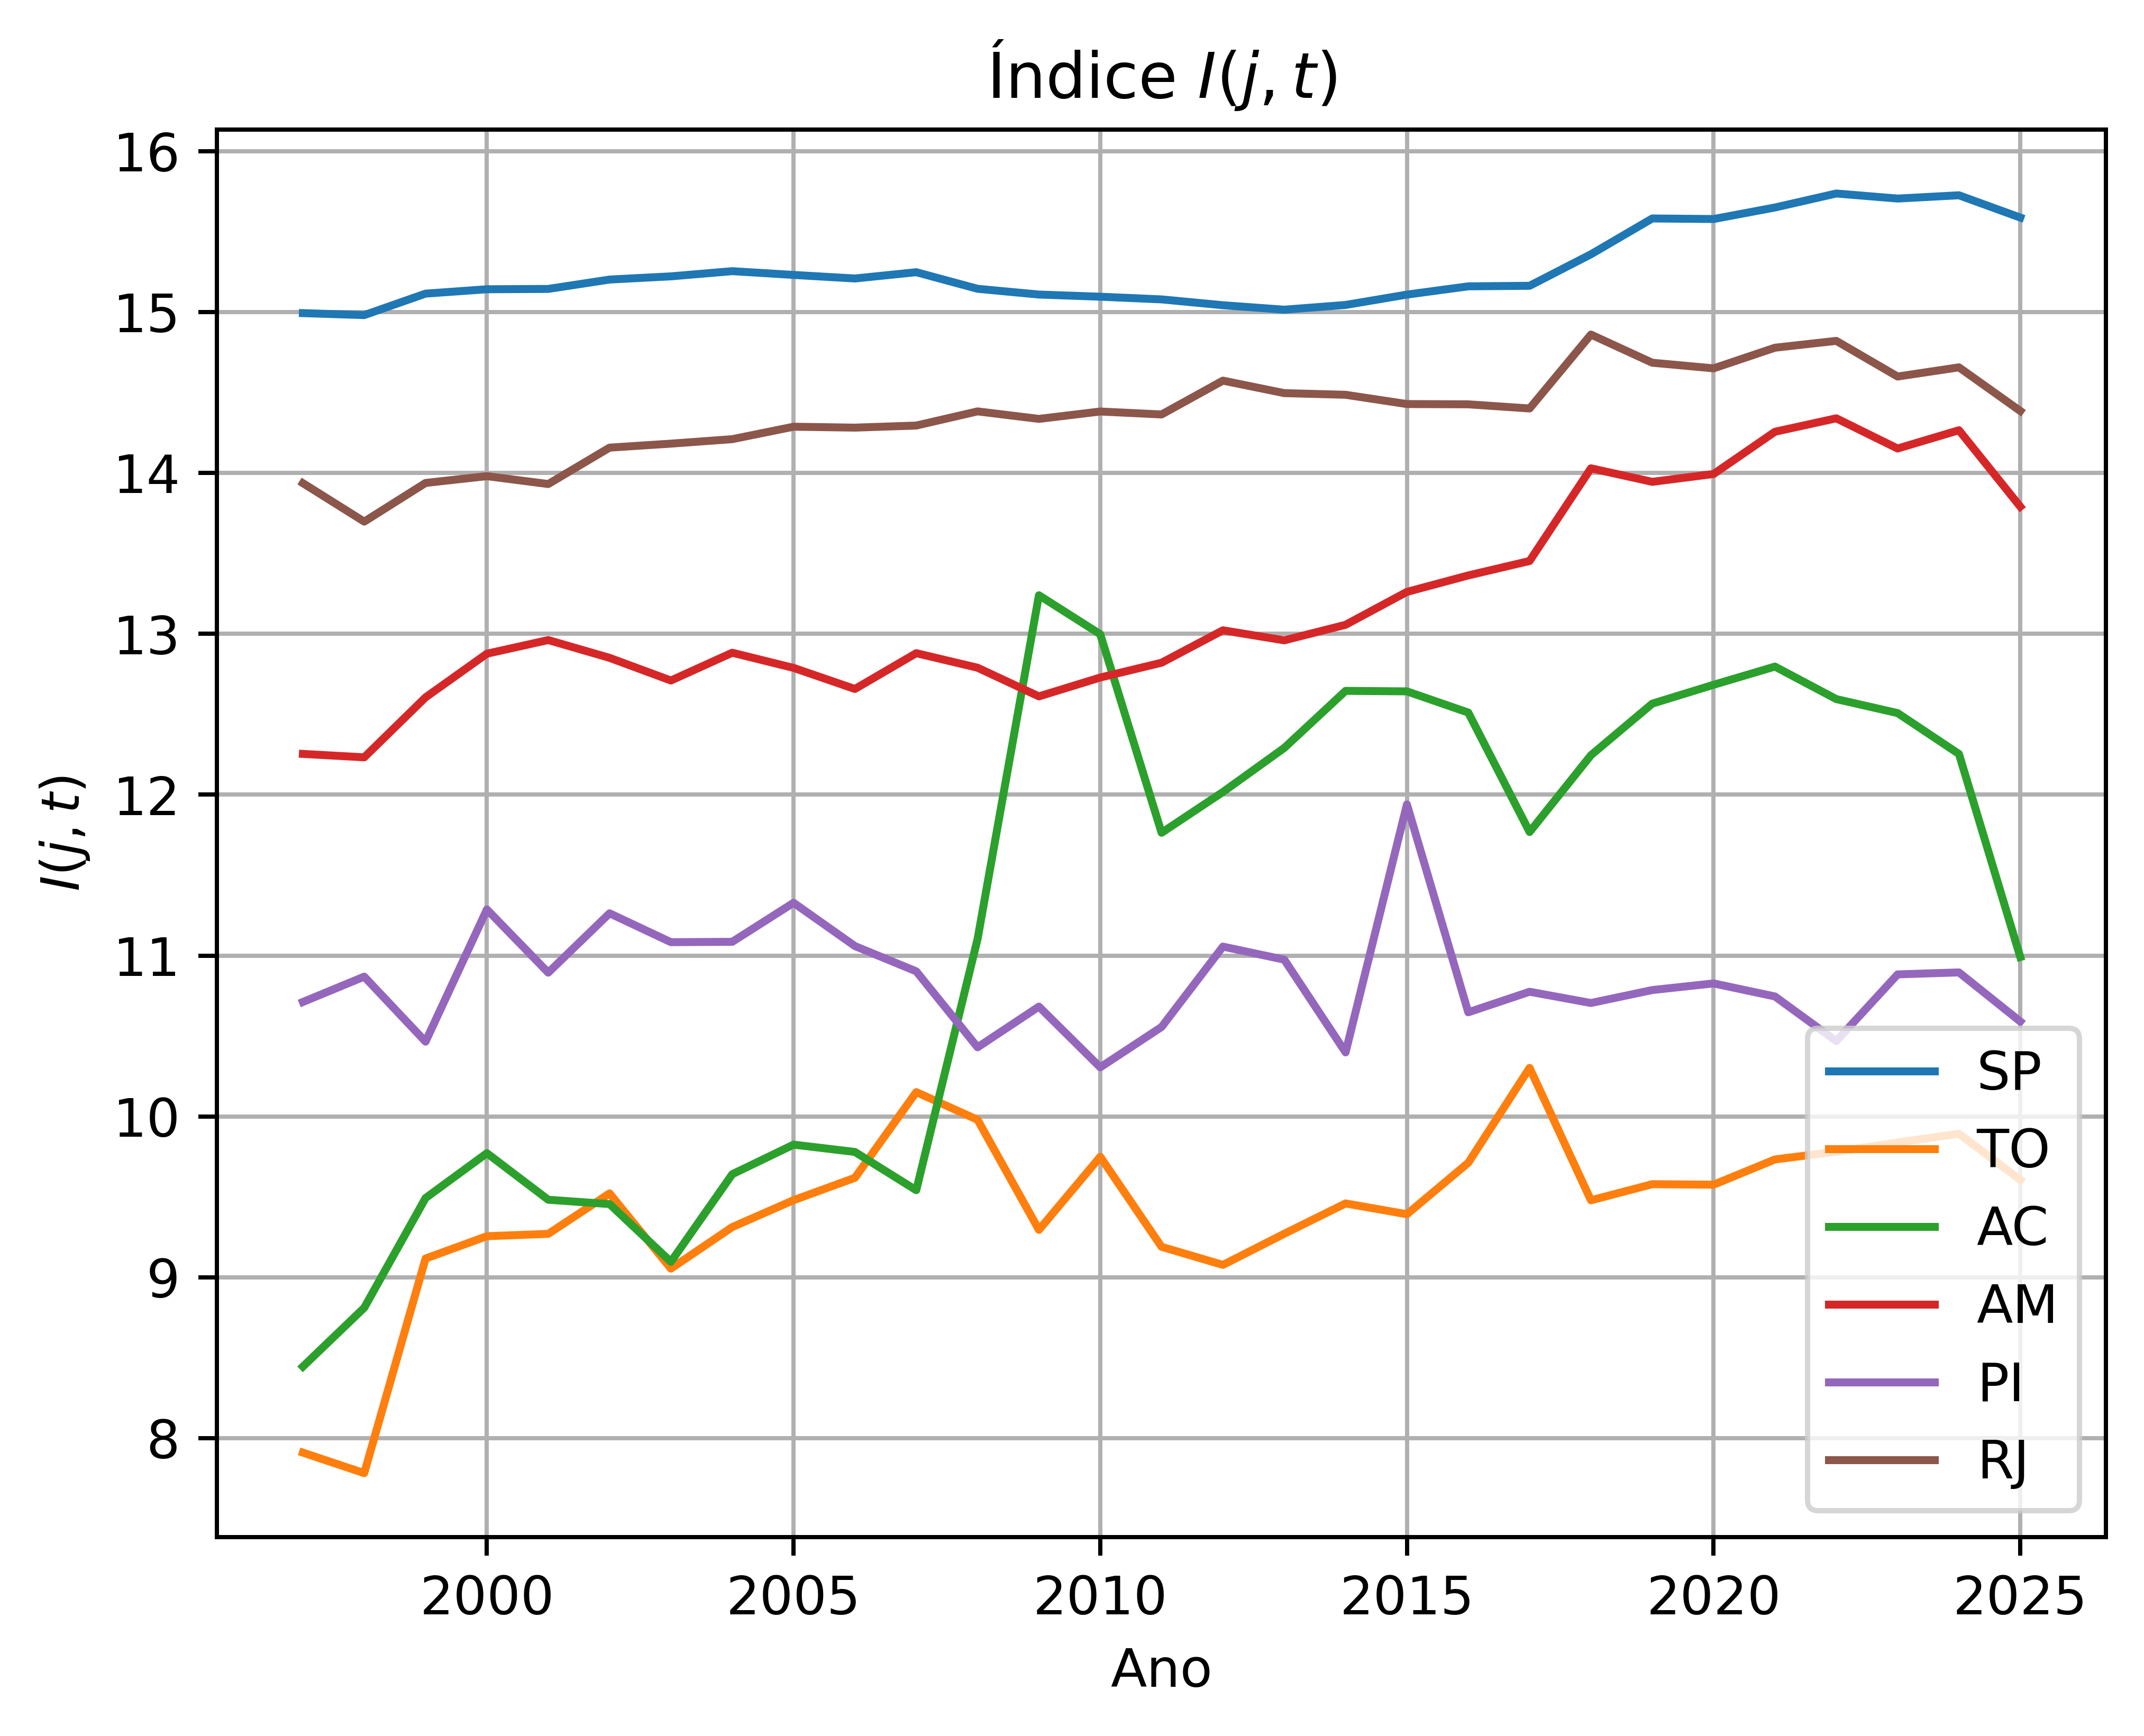

In [12]:
estados = ['SP','TO','AC','AM','PI','RJ']

fig, ax = plt.subplots(dpi = 720) 

for estado in estados: 
    
    ax.plot(df_final['CO_ANO'].unique(), df_final.loc[df_final['SG_UF_NCM'] == estado, 'entropia final'], label = estado)
    
ax.set(xlabel = 'Ano',
       ylabel = r'$I(j,t)$',
       title = r'Índice $I(j,t)$')

ax.grid()
ax.legend()

In [13]:
# salvando

df_final.to_excel('entropia.xlsx')

# Fazendo a regressão

In [14]:
# importando os dados 

df = pd.read_excel('entropia.xlsx')

df = df[['CO_ANO','SG_UF_NCM','entropia']]

df

,CO_ANO,SG_UF_NCM,entropia
0,1997,AC,7.077618
1,1998,AC,7.752297
2,1999,AC,7.250720
3,2000,AC,6.956234
4,2001,AC,6.633558
...,...,...,...
868,2011,ZN,7.563929
869,2012,ZN,7.560951
870,2013,ZN,7.529665
871,2014,ZN,7.504867


In [16]:
# importando os dados para renda per capita 

df2 = pd.read_excel("pib pc.xlsx")

df2 = df2[['Sigla','Ano','PIB_pc']]

df2

,Sigla,Ano,PIB_pc
0,AC,1997,3109.462541
1,AL,1997,2333.670847
2,AM,1997,5109.420467
3,AP,1997,5050.930657
4,BA,1997,2874.023028
...,...,...,...
616,RS,2021,50693.506053
617,SC,2021,58400.554005
618,SE,2021,22177.452854
619,SP,2021,58302.290199


In [17]:
# renomeando para dar o merge

df = df.rename(columns = {'CO_ANO':'Ano',
                          'SG_UF_NCM':'Sigla'})

df

,Ano,Sigla,entropia
0,1997,AC,7.077618
1,1998,AC,7.752297
2,1999,AC,7.250720
3,2000,AC,6.956234
4,2001,AC,6.633558
...,...,...,...
868,2011,ZN,7.563929
869,2012,ZN,7.560951
870,2013,ZN,7.529665
871,2014,ZN,7.504867


In [18]:
# juntando a estatística I(j,t) com os dados de renda per capita

df3 = pd.merge(df,df2, how = 'right')

df3

,Ano,Sigla,entropia,PIB_pc
0,1997,AC,7.077618,3109.462541
1,1997,AL,8.322190,2333.670847
2,1997,AM,8.147533,5109.420467
3,1997,AP,8.528804,5050.930657
4,1997,BA,8.388074,2874.023028
...,...,...,...,...
616,2021,RS,7.613680,50693.506053
617,2021,SC,7.681367,58400.554005
618,2021,SE,7.531501,22177.452854
619,2021,SP,7.898515,58302.290199


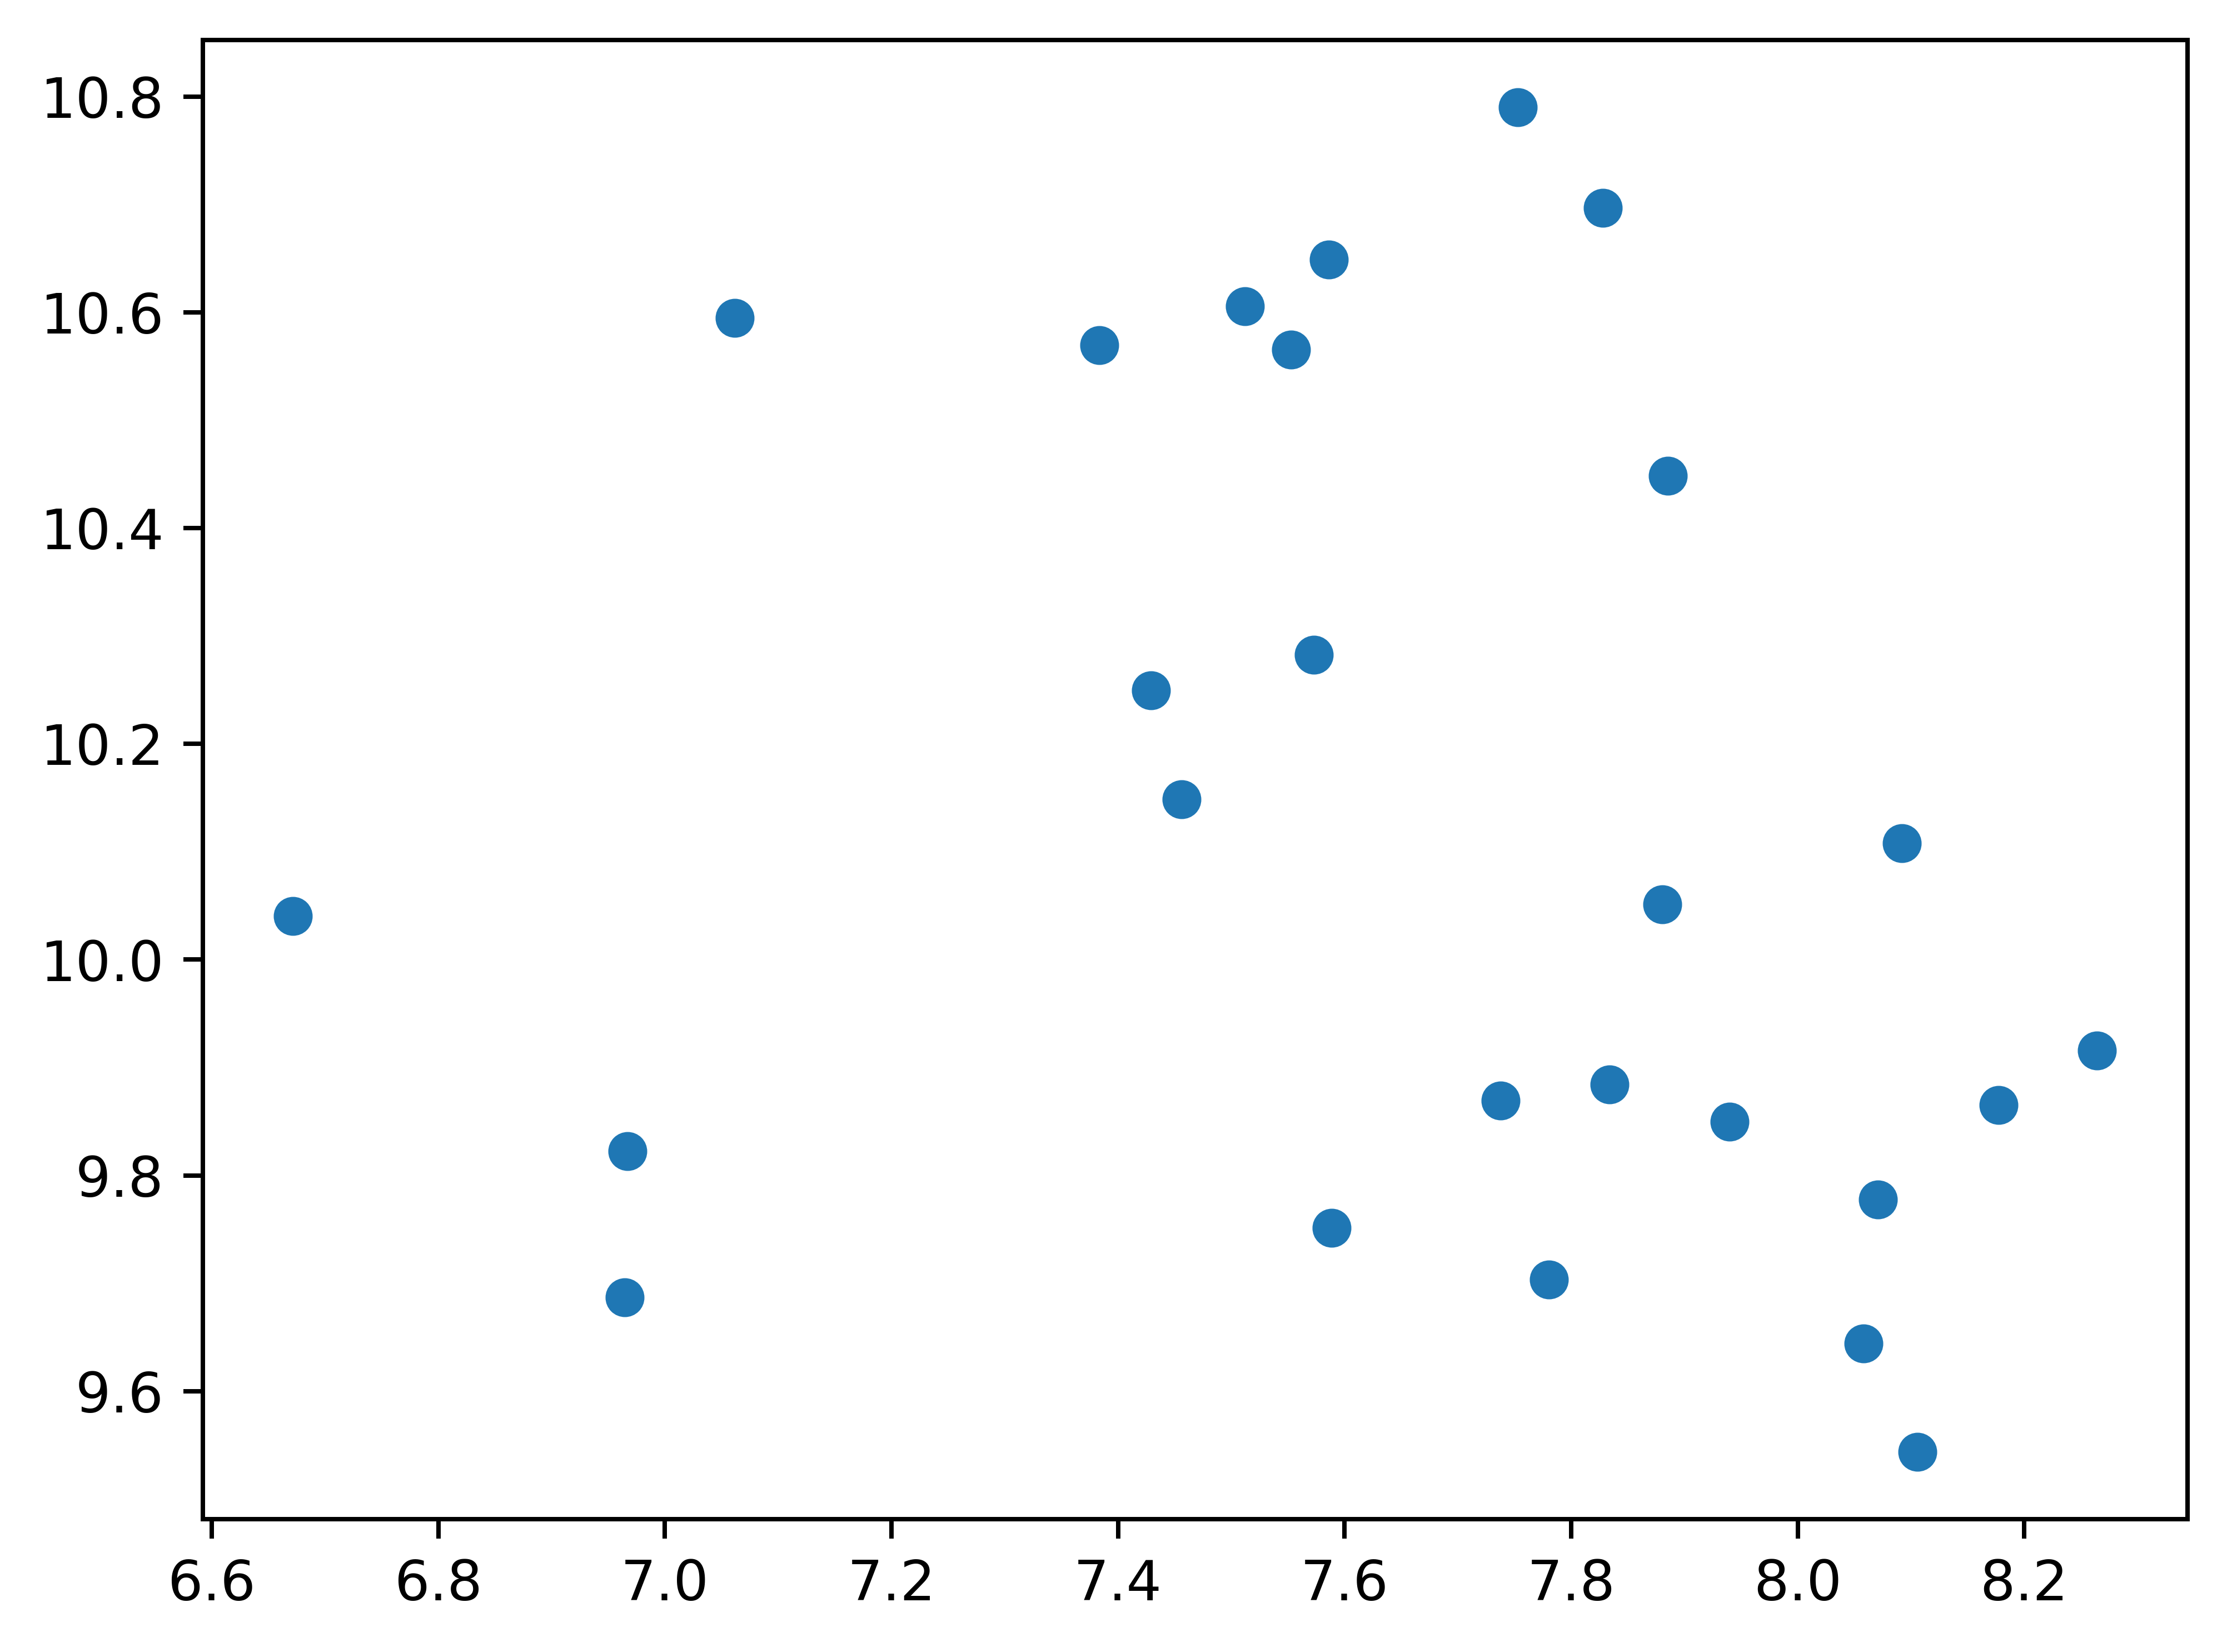

In [19]:
# fazendo um gráfico de pontos para o ano de 2018

a = df3.loc[df3['Ano'] == 2018,:]

# removendo o DF por ser um outlier

a = a.loc[a['Sigla'] != 'DF',:]

fig,ax = plt.subplots(dpi = 720)

ax.scatter(a['entropia'], np.log(a['PIB_pc']))



In [20]:
a.loc[a['PIB_pc'] == a['PIB_pc'].max(),:]

,Ano,Sigla,entropia,PIB_pc
538,2018,SP,7.75281,48542.239744


In [21]:
# rodando uma regressão simples para o ano de 2018

X = sm.add_constant(a['entropia'])

y = a['PIB_pc']

model = sm.OLS(y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PIB_pc   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9031
Date:                Fri, 25 Apr 2025   Prob (F-statistic):              0.351
Time:                        10:03:35   Log-Likelihood:                -276.81
No. Observations:                  26   AIC:                             557.6
Df Residuals:                      24   BIC:                             560.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.46e+04      4e+04      1.617      0.119   -1.79e+04    1.47e+05
entropia   -4950.9955   5209.718     -0.950      0.351   -1.57e+04    5801.334
==============================================================================
Omnibus:                        3.203   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.202   Jarque-Bera (JB):                2.524
Skew:                           0.637   Prob(JB):                        0.283
Kurtosis:                       2.158   Cond. No.                         150.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Em uma regressão simples para um ano específico, é possível de se notar que o coeficiente estimado para a estatística I não é estaticamente significativa a nenhum nível de confiança usual, já que seu p-valor é de 

In [22]:
# Estimando a regressão com efeitos fixos e efeitos de tempo

a = df3.loc[df3['Sigla'] != 'DF',:]

a = a.set_index(['Sigla','Ano'])

model = PanelOLS.from_formula('PIB_pc ~ entropia + TimeEffects + EntityEffects', data = a).fit()

model

Dep. Variable:,PIB_pc,R-squared:,0.0333
Estimator:,PanelOLS,R-squared (Between):,0.7915
No. Observations:,598,R-squared (Within):,-0.0120
Date:,"Fri, Apr 25 2025",R-squared (Overall):,0.5817
Time:,10:04:11,Log-likelihood,-5769.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,18.902
Entities:,26,P-value,0.0000
Avg Obs:,23.000,Distribution:,"F(1,549)"
Min Obs:,23.000,,
Max Obs:,23.000,F-statistic (robust):,18.902
